# Monitoring of methane (CH4) emission point sources using Amazon SageMaker geospatial capabilities

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-west-2/sagemaker-geospatial|methane-emission-monitoring|monitor_methane_ch4_emission_point_sources.ipynb)

---

In this notebook, we will demonstrate how to detect and monitor methane (CH₄) emissions from point sources. The approach utilizes Sentinel-2 satellite imagery to compute changes in reflectance values within the short-wave infrared (SWIR) bands. Drawing upon recent findings from the earth observation literature, you will learn to implement a custom methane detection algorithm, enabling you to identify and track methane leakages at various sites globally.

## Prerequisites

This notebook runs with the Geospatial 1.0 kernel with a `ml.geospatial.interactive` instance. Note that the following policies need to be attached to the execution role that you used to run this notebook:

- AmazonSageMakerFullAccess
- AmazonSageMakerGeospatialFullAccess

You can see the policies attached to the role in the IAM console under the permissions tab. If required, add the roles using the 'Add Permissions' button. 

In addition to these policies, ensure that the execution role's trust policy allows the SageMaker-GeoSpatial service to assume the role. This can be done by adding the following trust policy using the 'Trust relationships' tab:
```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "Service": [
                    "sagemaker.amazonaws.com",
                    "sagemaker-geospatial.amazonaws.com"
                ]
            },
            "Action": "sts:AssumeRole"
        }
    ]
}
```

## Setup SageMaker geospatial capabilities and imports

In [2]:
import os
import boto3
import json
import rioxarray
import numpy as np
import pandas as pd
import math
import warnings
from shapely import geometry
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.patches as patches

session = boto3.Session()
geospatial_client = session.client(service_name="sagemaker-geospatial")

## Define input variables

In [3]:
# coordinates and date for North Africa oil field
# see here for reference: https://doi.org/10.5194/amt-14-2771-2021
point_longitude = 5.9053
point_latitude = 31.6585
date_to_monitor = '2019-11-20'

# size of bounding box in each direction around point
distance_offset_meters = 1500

## Search matching Sentinel-2 satellite imagery

In [4]:
def bbox_around_point(lon, lat, distance_offset_meters=1500):
    # Equatorial radius (km) taken from https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html
    earth_radius_meters = 6378137
    lat_offset = math.degrees(distance_offset_meters / earth_radius_meters)
    lon_offset = math.degrees(distance_offset_meters / (earth_radius_meters * math.cos(math.radians(lat))))
    return geometry.Polygon([
        [lon - lon_offset, lat - lat_offset],
        [lon - lon_offset, lat + lat_offset],
        [lon + lon_offset, lat + lat_offset],
        [lon + lon_offset, lat - lat_offset],
        [lon - lon_offset, lat - lat_offset],
    ])

In [5]:
# generate bounding box and extract polygon coordinates
aoi_geometry = bbox_around_point(point_longitude, point_latitude, distance_offset_meters)
geometry.mapping(aoi_geometry)

{'type': 'Polygon',
 'coordinates': (((5.889469567720978, 31.645025270738206),
   (5.889469567720978, 31.671974729261795),
   (5.921130432279023, 31.671974729261795),
   (5.921130432279023, 31.645025270738206),
   (5.889469567720978, 31.645025270738206)),)}

In [6]:
def as_iso_date(date_str):
    # convert to datetime to validate format
    return datetime.strptime(date_str, '%Y-%m-%d').strftime('%Y-%m-%d')

def get_sentinel2_meta_data(target_date, aoi_geometry):
    search_params = {
        "Arn": "arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/nmqj48dcu3g7ayw8",
        "RasterDataCollectionQuery": {
            "AreaOfInterest": {
                "AreaOfInterestGeometry": {
                    "PolygonGeometry": {
                        "Coordinates": geometry.mapping(aoi_geometry)['coordinates']
                    }
                }
            },
            "TimeRangeFilter": {
                "StartTime": "{}T00:00:00Z".format(as_iso_date(target_date)),
                "EndTime": "{}T23:59:59Z".format(as_iso_date(target_date)),
            }
        },
    }

    s2_items = []
    next_token = True
    while next_token:
        search_result = geospatial_client.search_raster_data_collection(**search_params)
        for item in search_result["Items"]:
            s2_items.append(item)
        next_token = search_result.get("NextToken")
        search_params["NextToken"] = next_token
    return s2_items

In [7]:
# query raster data using SageMaker geospatial capabilities
sentinel2_items = get_sentinel2_meta_data(date_to_monitor, aoi_geometry)

### Inspect a single Sentinel-2 tile

In [8]:
import IPython.display

IPython.display.JSON(sentinel2_items[0])

<IPython.core.display.JSON object>

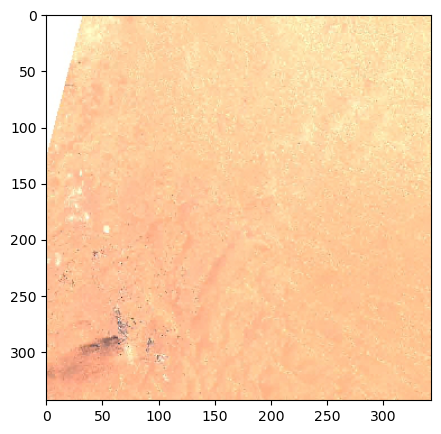

In [9]:
import rasterio
from rasterio.plot import show

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)
    src_thumbnail = rasterio.open(sentinel2_items[-1]['Assets']['thumbnail']['Href'])

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
show(src_thumbnail, ax=ax)
plt.show()

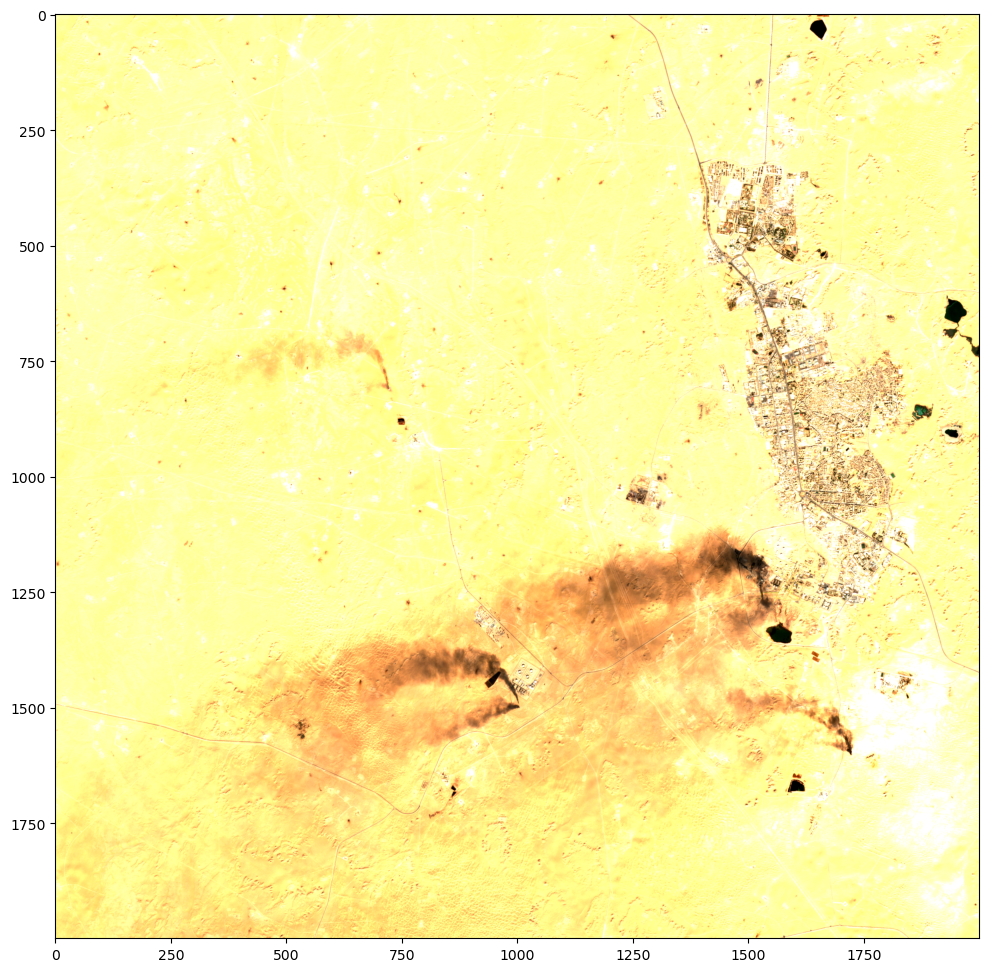

In [11]:
import rasterio
from rasterio.plot import show

src_visual = rasterio.open(sentinel2_items[-1]['Assets']['visual']['Href'])
data_visual = src_visual.read()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)
show(data_visual[:, 8000:10000, 500:2500], ax=ax)
plt.show()

### Visualize the area of interest

In [24]:
def s2_tile_id_to_cog_path(tile_id):
    parts = tile_id.split("_")
    s2_qualifier = "{}/{}/{}/{}/{}/{}".format(
        parts[1][0:2],
        parts[1][2],
        parts[1][3:5],
        parts[2][0:4],
        str(int(parts[2][4:6])),
        "_".join(parts)
    )
    return f"https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/{s2_qualifier}/"

def get_rgb_bands(lon, lat, s2_tile_id, distance_offset=1500, g="EPSG:4326"):
    aoi_geometry = bbox_around_point(lon, lat, distance_offset)
    s2_cog_prefix = s2_tile_id_to_cog_path(s2_tile_id)
    blue = rioxarray.open_rasterio(f"{s2_cog_prefix}/B02.tif", masked=True)
    green = rioxarray.open_rasterio(f"{s2_cog_prefix}/B03.tif", masked=True)
    red = rioxarray.open_rasterio(f"{s2_cog_prefix}/B04.tif", masked=True)

    bands = []
    for band in [red, green, blue]:
        kwargs = {"nodata": np.nan}
        band_reprojected = band.rio.reproject(output_projection, **kwargs)
        bands.append(band_reprojected.rio.clip(geometries=[geometry.mapping(aoi_geometry)]))
    return bands

def normalize_rgb_bands(rgb_bands):
    bands = []
    for band in rgb_bands:
        img_arr = band.to_numpy()
        normalized = img_arr / np.amax(img_arr)
        normalized = normalized * 255
        bands.append(normalized.astype(np.uint8)[0])
    return np.array(bands)

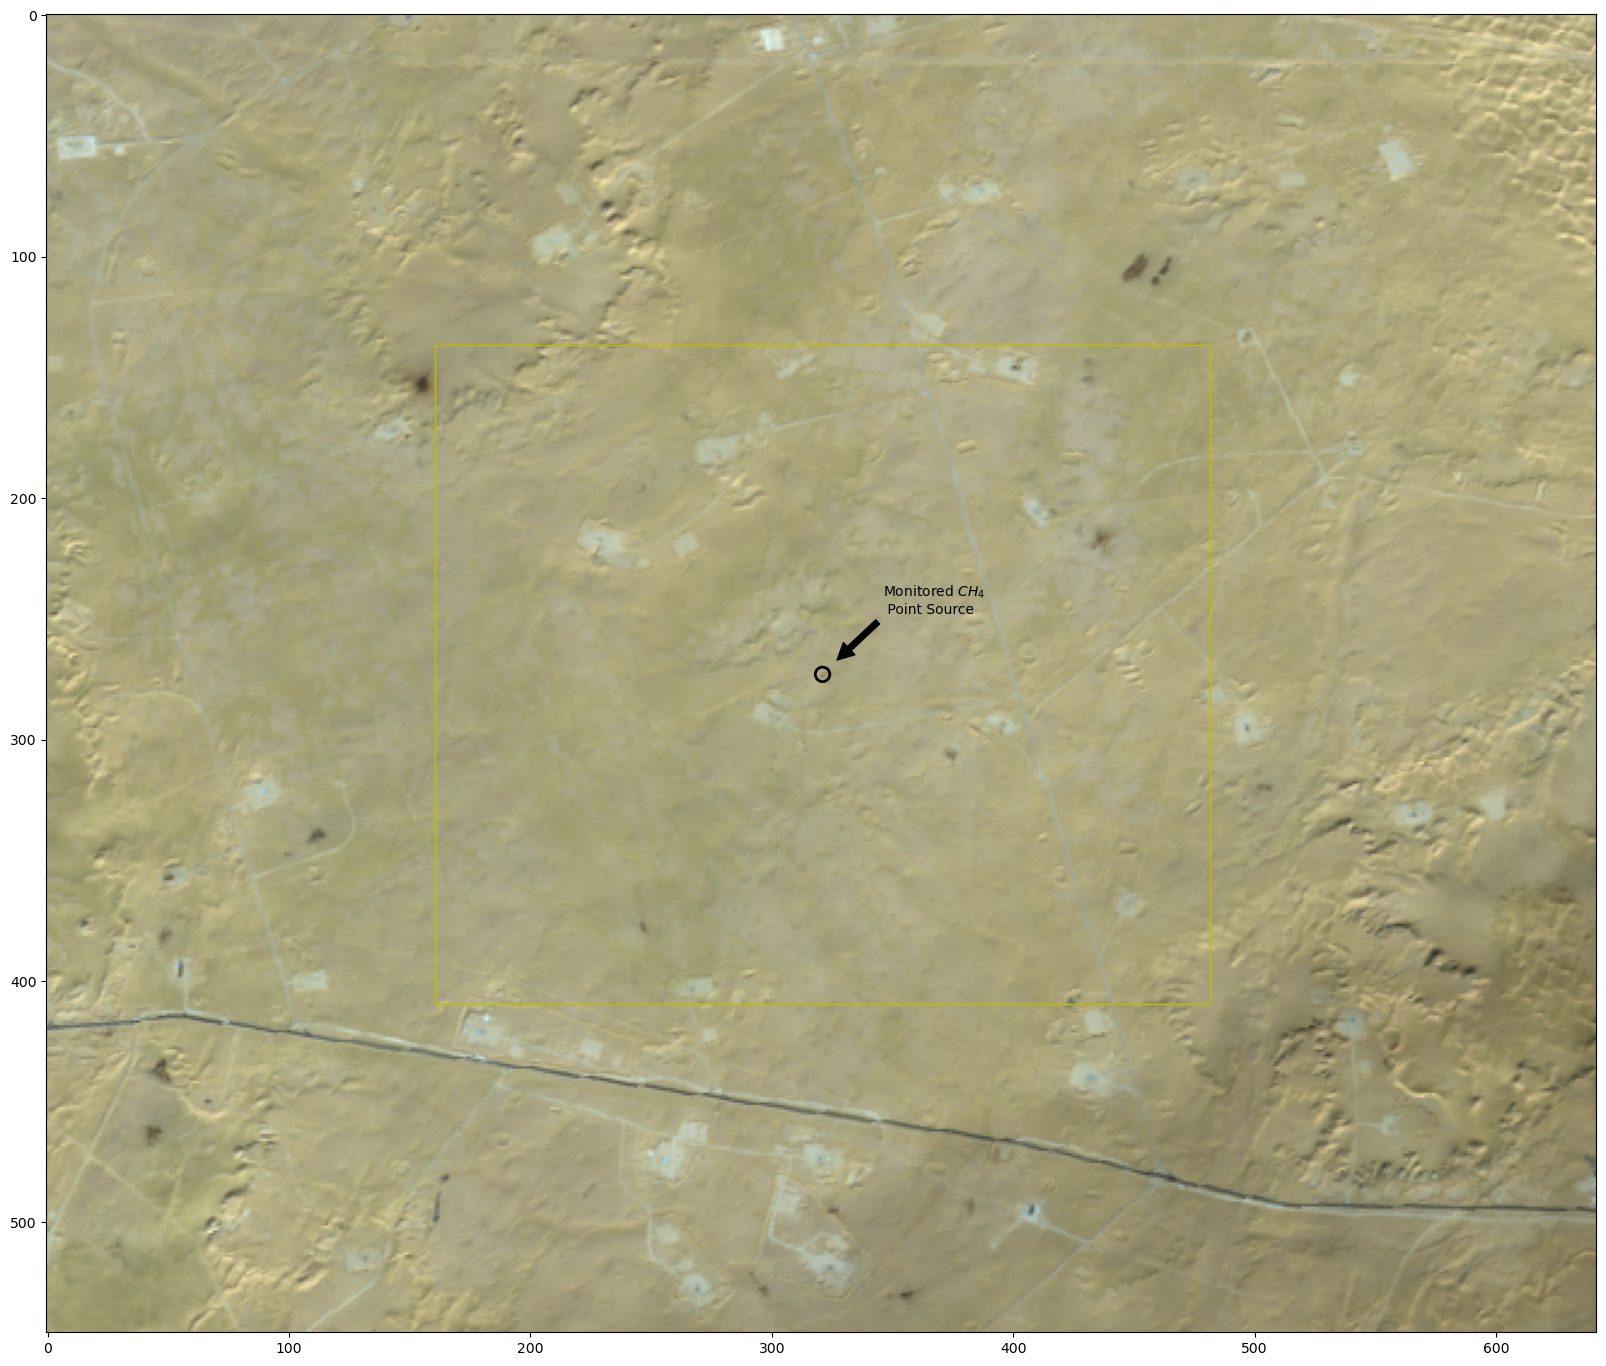

In [14]:
sentinel2_tile_id = sentinel2_items[-1]["Id"]

preview_distance_offset = 3000

visual_bands = get_rgb_bands(
    point_longitude, 
    point_latitude,
    sentinel2_tile_id, 
    distance_offset=preview_distance_offset
)
rgb = normalize_rgb_bands(visual_bands).transpose(1, 2, 0)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(rgb)

height = rgb.shape[0]
width = rgb.shape[1]
y_m_per_pixel = preview_distance_offset * 2 / height
x_m_per_pixel = preview_distance_offset * 2 / width

y_distance_offset = distance_offset_meters / y_m_per_pixel
x_distance_offset = distance_offset_meters / x_m_per_pixel

p = patches.Circle(
    (width/2, height/2),
    radius=3,
    linewidth=2, 
    edgecolor='black', 
    facecolor='none'
)

rect = patches.Rectangle(
    (width/2 - x_distance_offset, height/2 - y_distance_offset), 
    x_distance_offset * 2, 
    y_distance_offset * 2, 
    linewidth=1, 
    edgecolor='y', 
    facecolor='none'
)
ax.add_patch(p)
ax.add_patch(rect)

ax.annotate(
    'Monitored $CH_4$\n Point Source', 
    xy=(width/2 + 5, height/2 - 5), 
    xytext=(width/2 + 25, height/2 - 25), 
    arrowprops=dict(facecolor='black', shrink=0.05),ha='left'
)

plt.show()

## Approximate representative baseline date and corresponding Sentinel-2 tile

In [15]:
def download_from_s3(s3_obj_url, local_dir, local_file_fn=None, requester_pays=False):
        os.makedirs(local_dir, exist_ok=True)
        if local_file_fn is None:
            local_file_path = os.path.join(local_dir, s3_obj_url.split("/")[-1])
        else:
            local_file_path = local_file_fn(local_dir, s3_obj_url)

        target_bucket_name = s3_obj_url.split("/")[2]
        target_bucket_ob_key = "/".join(s3_obj_url.split("/")[3:])

        s3_bucket = session.resource("s3").Bucket(target_bucket_name)
        if requester_pays:
            s3_bucket.download_file(target_bucket_ob_key, local_file_path, ExtraArgs={"RequestPayer": "requester"})
        else:
            s3_bucket.download_file(target_bucket_ob_key, local_file_path)
        return local_file_path

def s2_tile_id_to_s2l1c_s3_url(tile_id):
        parts = tile_id.split("_")
        s2l1c_qualifier = "{}/{}/{}/{}/{}/{}/0".format(
            parts[1][0:2],
            parts[1][2],
            parts[1][3:5],
            parts[2][0:4],
            str(int(parts[2][4:6])),
            str(int(parts[2][6:8]))
        )
        return f"s3://sentinel-s2-l1c/tiles/{s2l1c_qualifier}/"

def get_s2l1c_band_data_xarray(s2_tile_id, band_id, clip_geometry=None, cloud_mask=True):
    data_dir = "data/s2l1c/"
    s3_prefix = s2_tile_id_to_s2l1c_s3_url(s2_tile_id)

    local_tile_path = download_from_s3(
        f"{s3_prefix}{band_id}.jp2", 
        data_dir,
        local_file_fn=lambda local_dir, s3_obj_url: os.path.join(data_dir, f"{s2_tile_id}_{band_id}.jp2"),
        requester_pays=True
    )

    band_data_epsg_32631 = rioxarray.open_rasterio(local_tile_path, masked=True)

    if cloud_mask:
        s2_cog_prefix = s2_tile_id_to_cog_path(s2_tile_id)
        scl_mask = rioxarray.open_rasterio(f"{s2_cog_prefix}/SCL.tif", masked=True)

        # no interpolation needed, as long as target band and scl mask have identical spatial resolution
        band_data_epsg_32631 = band_data_epsg_32631.where((scl_mask != 8) & (scl_mask != 9) & (scl_mask != 10))

    kwargs = {"nodata": np.nan}
    band_data_epsg_4326 = band_data_epsg_32631.rio.reproject("EPSG:4326", **kwargs)
    if clip_geometry is None:
        return band_data_epsg_4326
    return band_data_epsg_4326.rio.clip(geometries=[geometry.mapping(clip_geometry)])

In [16]:
def approximate_best_baseline_date(lon, lat, date_to_monitor, distance_offset=1500, cloud_mask=True, day_offset=30):
    # initialize AOI and other parameters
    aoi_geometry = bbox_around_point(lon, lat, distance_offset)

    BAND_12_SWIR22 = "B12"

    max_mean_swir = None
    ref_s2_tile_id = None
    ref_target_date = date_to_monitor   

    # loop over n=day_offset previous days
    for day_delta in range(-1 * day_offset, 0):
        date_time_obj = datetime.strptime(date_to_monitor, '%Y-%m-%d')
        target_date = (date_time_obj + timedelta(days=day_delta)).strftime('%Y-%m-%d')
        
        # get Sentinel-2 tiles for current date
        s2_tiles_for_target_date = get_sentinel2_meta_data(target_date, aoi_geometry)

        # loop over available tiles for current date
        for s2_tile_meta in s2_tiles_for_target_date:
            s2_tile_id_to_test = s2_tile_meta['Id']
            target_band_data = get_s2l1c_band_data_xarray(s2_tile_id_to_test, BAND_12_SWIR22, clip_geometry=aoi_geometry, cloud_mask=cloud_mask)

            # compute mean reflectance of SWIR band
            mean_swir = target_band_data.sum() / target_band_data.count()
            visible_area_ratio = target_band_data.count() / (target_band_data.shape[1] * target_band_data.shape[2])

            # ensure the visible/non-clouded area is adequately large
            if visible_area_ratio <= 0.7: 
                continue

            # update maximum ref_s2_tile_id and ref_target_date if applicable
            if max_mean_swir is None or mean_swir > max_mean_swir:
                max_mean_swir = mean_swir
                ref_s2_tile_id = s2_tile_id_to_test
                ref_target_date = target_date

    return (ref_s2_tile_id, ref_target_date)

In [17]:
baseline_s2_tile_id, baseline_date = approximate_best_baseline_date(
    point_longitude, 
    point_latitude,
    date_to_monitor,
    day_offset=45,
    distance_offset=distance_offset_meters
)

print(baseline_date)
print(baseline_s2_tile_id)

2019-10-06
S2B_32SKA_20191006_0_L2A


## Compute change in fractional reflectance

In [18]:
BAND_11_SWIR16 = "B11"
BAND_12_SWIR22 = "B12"

def compute_correction_factor(tif_y, tif_x):
    """
    Computes a correction factor c via linera regression
    with the following equation: tif_y = c*tif_x
    """

    # get flattened arrays for regression
    y = np.array(tif_y.values.flatten())
    x = np.array(tif_x.values.flatten())

    np.nan_to_num(y, copy=False)
    np.nan_to_num(x, copy=False)

    assert y.shape==x.shape, "Shapes of two provided TIFs are incompatible!"

    # fit linear model using least squares regression
    x = x[:,np.newaxis]
    c, _, _, _ = np.linalg.lstsq(x, y, rcond=None)

    return c[0]

def compute_MB_MP(l1_b11_noplume, l1_b12_noplume, l1_b11_monitor, l1_b12_monitor, correction=True):
    """
    Compute multi-band-multi-pass change in transmittance
    """
    # get correction factor
    c_monitor = compute_correction_factor(tif_y=l1_b11_monitor, tif_x=l1_b12_monitor)
    c_noplume = compute_correction_factor(tif_y=l1_b11_noplume, tif_x=l1_b12_noplume)
    # get corrected fractional reflectance change
    if correction:
        MB_MP = ((c_monitor*l1_b12_monitor-l1_b11_monitor)/l1_b11_monitor)-((c_noplume*l1_b12_noplume-l1_b11_noplume)/l1_b11_noplume)
    else:
        MB_MP = ((l1_b12_monitor-l1_b11_monitor)/l1_b11_monitor)-((l1_b12_noplume-l1_b11_noplume)/l1_b11_noplume)
    return MB_MP

def run_full_fractional_reflectance_change_routine(lon, lat, date_monitor, baseline_s2_tile_id, distance_offset=1500, cloud_mask=True):
    s2_tile_id_noplume = baseline_s2_tile_id
    
    aoi_geometry = bbox_around_point(lon, lat, distance_offset)

    s2_meta_monitor = get_sentinel2_meta_data(date_monitor, aoi_geometry)
    grid_id = s2_tile_id_noplume.split("_")[1]
    s2_tile_id_monitor = list(filter(lambda x: f"_{grid_id}_" in x["Id"], s2_meta_monitor))[0]["Id"]

    l1_swir16_b11_noplume = get_s2l1c_band_data_xarray(s2_tile_id_noplume, BAND_11_SWIR16, clip_geometry=aoi_geometry, cloud_mask=cloud_mask)
    l1_swir22_b12_noplume = get_s2l1c_band_data_xarray(s2_tile_id_noplume, BAND_12_SWIR22, clip_geometry=aoi_geometry, cloud_mask=cloud_mask)
    l1_swir16_b11_monitor = get_s2l1c_band_data_xarray(s2_tile_id_monitor, BAND_11_SWIR16, clip_geometry=aoi_geometry, cloud_mask=cloud_mask)
    l1_swir22_b12_monitor = get_s2l1c_band_data_xarray(s2_tile_id_monitor, BAND_12_SWIR22, clip_geometry=aoi_geometry, cloud_mask=cloud_mask)

    mb_mp = compute_MB_MP(
        l1_swir16_b11_noplume,
        l1_swir22_b12_noplume,
        l1_swir16_b11_monitor,
        l1_swir22_b12_monitor
    )
    return mb_mp.rio.set_attrs({
        "s2_tile_id_baseline": s2_tile_id_noplume,
        "s2_tile_id_monitor": s2_tile_id_monitor,
    })

In [19]:
change_reflectance = run_full_fractional_reflectance_change_routine(
    point_longitude, 
    point_latitude,
    date_to_monitor,
    baseline_s2_tile_id,
    distance_offset=distance_offset_meters
)

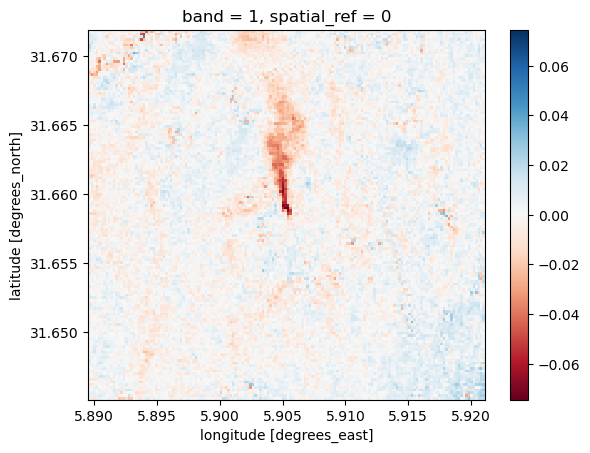

In [22]:
plot = change_reflectance.plot(cmap = "RdBu")

## Compare visual imagery with detected plume mask

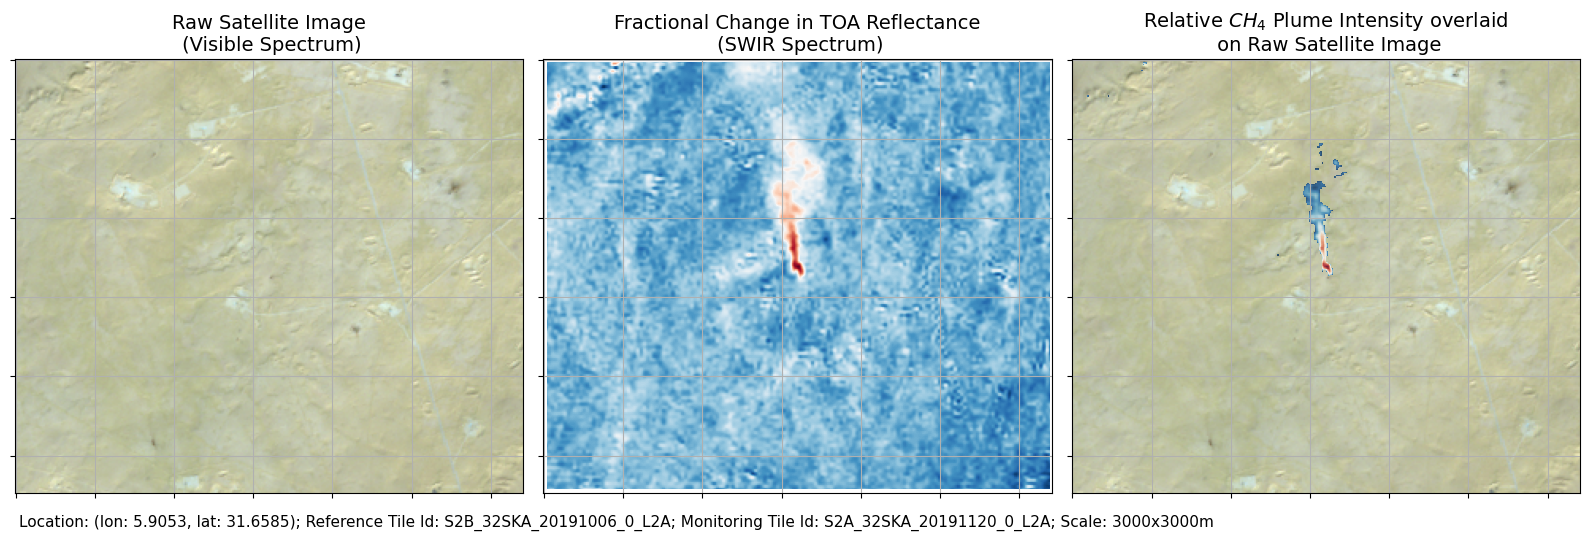

In [31]:
output_projection="EPSG:4326"
treshold_value = -0.025

visual_bands = get_rgb_bands(
    point_longitude, 
    point_latitude,
    change_reflectance.attrs['s2_tile_id_monitor'], 
    distance_offset=distance_offset_meters,
    output_projection=output_projection
)
rgb = normalize_rgb_bands(visual_bands).transpose(1, 2, 0)

change_reflectance_reprojected = change_reflectance.rio.reproject(output_projection)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    cr_interp = change_reflectance_reprojected.interp(x=visual_bands[0]["x"], y=visual_bands[0]["y"])
    cr = cr_interp.to_numpy()[0]

cr_masked = cr.copy()
cr_masked[cr_masked > treshold_value] = np.nan

m = np.ma.array(cr_masked, mask=cr_masked==np.nan)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 10),sharex=True, sharey=True)

ax = axes[0]
ax.imshow(rgb)
ax.set_title("Raw Satellite Image\n (Visible Spectrum)", fontsize=14)

ax = axes[1]
ax.imshow(cr, cmap='RdBu') # <-- uses interpolated data
ax.set_title("Fractional Change in TOA Reflectance\n (SWIR Spectrum)", fontsize=14)

ax = axes[2]
ax.imshow(rgb)
ax.imshow(m, alpha=0.8, cmap='RdBu')
ax.set_title("Relative $CH_4$ Plume Intensity overlaid\n on Raw Satellite Image", fontsize=14)

for ax in axes:
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

txt=f"Location: (lon: {point_longitude}, lat: {point_latitude}); Reference Tile Id: {change_reflectance.attrs['s2_tile_id_baseline']}; Monitoring Tile Id: {change_reflectance.attrs['s2_tile_id_monitor']}; Scale: {distance_offset_meters*2}x{distance_offset_meters*2}m"
plt.figtext(0.015, 0.25, txt, wrap=False, horizontalalignment='left', fontsize=11)

plt.tight_layout()

plt.show()

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-east-1/sagemaker-geospatial|methane-emission-monitoring|monitor_methane_ch4_emission_point_sources.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-east-2/sagemaker-geospatial|methane-emission-monitoring|monitor_methane_ch4_emission_point_sources.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-west-1/sagemaker-geospatial|methane-emission-monitoring|monitor_methane_ch4_emission_point_sources.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ca-central-1/sagemaker-geospatial|methane-emission-monitoring|monitor_methane_ch4_emission_point_sources.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/sa-east-1/sagemaker-geospatial|methane-emission-monitoring|monitor_methane_ch4_emission_point_sources.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-1/sagemaker-geospatial|methane-emission-monitoring|monitor_methane_ch4_emission_point_sources.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-2/sagemaker-geospatial|methane-emission-monitoring|monitor_methane_ch4_emission_point_sources.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-3/sagemaker-geospatial|methane-emission-monitoring|monitor_methane_ch4_emission_point_sources.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-central-1/sagemaker-geospatial|methane-emission-monitoring|monitor_methane_ch4_emission_point_sources.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-north-1/sagemaker-geospatial|methane-emission-monitoring|monitor_methane_ch4_emission_point_sources.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-southeast-1/sagemaker-geospatial|methane-emission-monitoring|monitor_methane_ch4_emission_point_sources.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-southeast-2/sagemaker-geospatial|methane-emission-monitoring|monitor_methane_ch4_emission_point_sources.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-northeast-1/sagemaker-geospatial|methane-emission-monitoring|monitor_methane_ch4_emission_point_sources.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-northeast-2/sagemaker-geospatial|methane-emission-monitoring|monitor_methane_ch4_emission_point_sources.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-south-1/sagemaker-geospatial|methane-emission-monitoring|monitor_methane_ch4_emission_point_sources.ipynb)
